## Class 6: Random Forests
---

A few examples are reproduced or adapted from

https://github.com/jakevdp/PythonDataScienceHandbook

The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT).


# 1.  $\underline{{\rm Random\ Forest\ Classifier}}$

In [1]:
#Let's start with our imports, you might notice some new ones
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_validate
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

## 1.1 Why choose an ensemble method (such as a RF)

Let's make up some data:

In [2]:
from sklearn.datasets import make_blobs

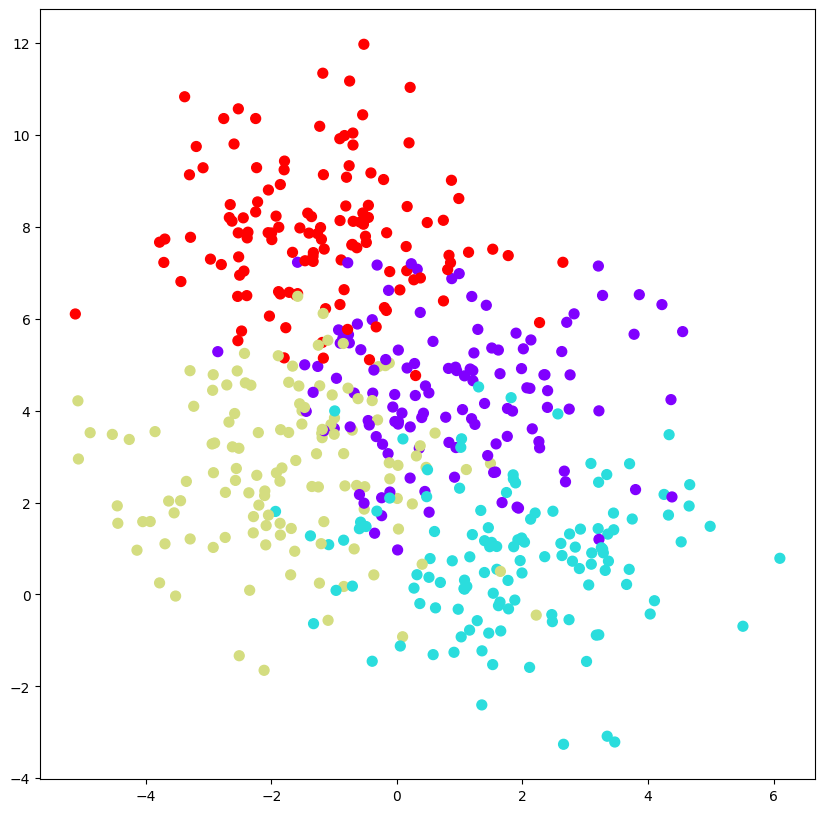

In [3]:
pos, colors = make_blobs(n_samples=500, centers=4,
                  random_state=0, cluster_std=1.5)
plt.figure(figsize=(10,10))
plt.scatter(pos[:, 0], pos[:, 1], c=colors, s=50, cmap='rainbow');

How should we attack this problem as a classification problem? But first, why might we need an ensemble learning method and not just a single decsion tress?

We can see that there are several areas of overlapping. How might one single tree make these splits?

Let's do a 5 fold cross validation with a decision tree to get an idea of the performance and whether we are suffering from high bias or high variance.

In [4]:
#I'm going to make a random seed to use throughout my whole notebbok!
seed = 5

In [5]:
model = DecisionTreeClassifier()

In [6]:
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

In [7]:
scores = cross_validate(model, pos, colors, cv=cv, scoring = 'accuracy', \
                        return_train_score = True)
scores

{'fit_time': array([0.00435591, 0.01889896, 0.0027616 , 0.00691175, 0.00276256]),
 'score_time': array([0.00906205, 0.00184393, 0.00155044, 0.00755811, 0.00159121]),
 'test_score': array([0.71, 0.72, 0.76, 0.73, 0.72]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [8]:
    test = scores['test_score']
    train = scores['train_score']

    print('Test scores:', test.mean(), test.std())
    print('Train scores:', train.mean(), train.std())

Test scores: 0.728 0.01720465053408527
Train scores: 1.0 0.0


Let's take a look at our scores. Are they within one standard deviation? What dow we think about the difference between the training and test scores?

While the dataset seems balanced, in which case bias is low, there seems to be some high variance (over fitting). This is where a Random forest could come in handy!

Let's do the same thing as above but using a Random Forest with standard parameters.

In [9]:
model_rf = RandomForestClassifier(n_estimators=50)

In [10]:
scores = cross_validate(model_rf, pos, colors, cv=cv, scoring = 'accuracy', \
                        return_train_score = True)
scores

{'fit_time': array([0.28439355, 0.23325038, 0.28606081, 0.28100848, 0.36570668]),
 'score_time': array([0.00932479, 0.00857973, 0.02311563, 0.00955725, 0.01319861]),
 'test_score': array([0.71, 0.73, 0.81, 0.78, 0.82]),
 'train_score': array([1.   , 0.995, 0.995, 1.   , 1.   ])}

In [11]:
test = scores['test_score']
train = scores['train_score']

print('Test scores:', test.mean(), test.std())
print('Train scores:', train.mean(), train.std())

Test scores: 0.77 0.04335896677735761
Train scores: 0.998 0.0024494897427831805


Ok, while those aren't great scores, we can see that the RF performed slightly better.
#### A Random Forest ensemble characteristic lessens overfitting.

## 1.2 Hyperparameter tuning with a Grid Search

Scikiit-learn comes with great buil-in finctions that search the parameter space of hyperparameters to find combinations that result in the best model. Let's see how it's implimented.

We begin by creating a dictionary that holds all of the hyperparameters we want to explore.

In [12]:
### LET'S DESCIBE THE SYNTAX
hyperparam_grid = {
'max_depth': [7,15],
#'max_features': [2, 4],
'min_samples_leaf': [2, 5, 10],
#'min_samples_split': [2,3, 5],
'n_estimators': [50, 100]
}
### AND THERE ARE SO MANY MORE OPTIONS

#### Note: The typical hyperparameters that one tunes in the RF are: n_estimators, min_samples_leaf, min_samples_split, max_depth, and max_features.

n_estimators (number of trees) increasing number of trees is typycally good but at some point it doesn't get any better and more trees=more time.

max_features is a good parameter to explore (it's the size of the subset of random features used to create splits) but in this data set there are only two features so not much fun.

min_samples_split and min_samples_leaf are the minimum amount of examples that need to be in each split/leaf node. Setting one of these parameters to a higher number (with respect to their default values of 2/1 respectively) is a great way to avoid overfitting.

Max_depth is the maximum number of splits in a tree. This is also a good parameter to tune to avoid overfitting.

#### Now we create a variable that will hold the result of our grid search, like so:

In [13]:
search_1 = GridSearchCV(estimator=RandomForestClassifier(), param_grid = hyperparam_grid,\
                        scoring='recall_weighted', cv = cv, verbose = 1,\
                           return_train_score=True)

In [14]:
### this is for timing how long my code takes
import time

And we perform the search

In [15]:
start = time.time()
search_1.fit(pos, colors)
print('number of minutes to perform the serach:', (time.time() - start)/60)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
number of minutes to perform the serach: 0.30644611914952596


In [16]:
print('mean test scores:',search_1.cv_results_['mean_test_score'])
print('std test scores:',search_1.cv_results_['std_test_score'])
print('mean train scores:',search_1.cv_results_['mean_train_score'])
print('std train scores:',search_1.cv_results_['std_train_score'])
print('best test score:',search_1.best_score_)

mean test scores: [0.794 0.784 0.78  0.776 0.774 0.788 0.774 0.788 0.784 0.772 0.788 0.77 ]
std test scores: [0.03878144 0.04630335 0.0409878  0.04586938 0.0397995  0.04069398
 0.03666061 0.044      0.04223742 0.03969887 0.03709447 0.04335897]
mean train scores: [0.9115 0.9115 0.8675 0.865  0.837  0.8405 0.9365 0.941  0.869  0.8665
 0.84   0.8445]
std train scores: [0.00969536 0.01270827 0.01095445 0.00758288 0.01041633 0.014
 0.01504992 0.01007472 0.00982344 0.01079352 0.01024695 0.01155422]
best test score: 0.794


So what do we notice?

And now let's see what best hyperparameter values our serach found:`m

In [17]:
results_1 = search_1.best_params_
results_1

{'max_depth': 7, 'min_samples_leaf': 2, 'n_estimators': 50}

Ok! Let's create a model and train.

First thing's first... split the data

In [18]:
### WHAT ARE OUR FEATURES AND TARGETS???
features = pos
target   = colors

In [19]:
### Another way to compliment looking at a visual representation of a distribution is to use np.unique
### to get numerical values

classes, counts = np.unique(target, return_counts=True)
print(classes)
print(counts)

[0 1 2 3]
[125 125 125 125]


So we see we have 4 classes  - 0,1,2,3 - and they each have 125 data points (instances) in each class.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,\
                                                    random_state=seed)

In [21]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3]), array([104,  95,  98, 103]))

In [22]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3]), array([21, 30, 27, 22]))

In [23]:
### LET"S BUILD OUR MODEL USING THE GRID SERACH RESULTS
### We plug in the results from the dictionary that holds the best_results_
model_1 = RandomForestClassifier(n_estimators=results_1['n_estimators'],\
                                 max_depth=results_1['max_depth'],\
                                 min_samples_leaf=results_1['min_samples_leaf'])

# $\underline{{\rm Exercise\ A.}}$
Please complete the procedure! Your turn to do the:
- fitting
- prediction
- evaluate the model using a confusion matrix and a numerical score

In [24]:
model_1.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=2, n_estimators=50)

In [25]:
y_pred_1 = model_1.predict(X_test)

In [26]:
metrics.accuracy_score(y_test, y_pred_1)

0.72

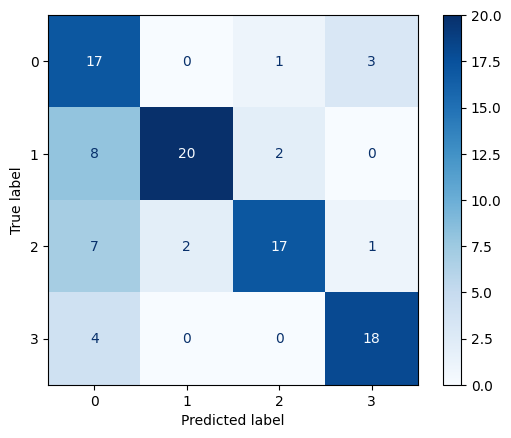

In [27]:
ConfusionMatrixDisplay.from_estimator(model_1, X_test,y_test,\
                                           cmap='Blues')

Rerun the confusin matrix and set normalize='pred'

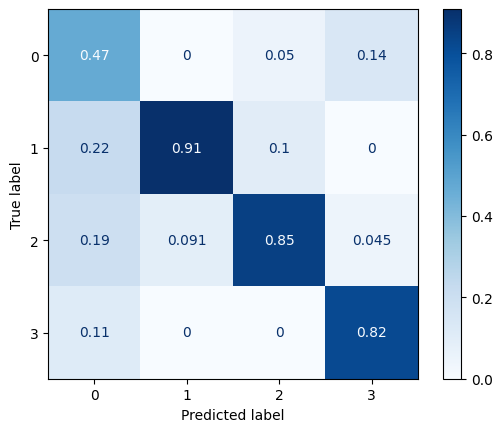

In [28]:
ConfusionMatrixDisplay.from_estimator(model_1, X_test,y_test,\
                                           cmap='Blues', normalize='pred')

You can read all about the RF Classifier here:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# 2.  $\underline{{\rm Splitting\ Imbalanced\ Data}}$

What happens if our data is seriously imbalanced?

In [29]:
blob_dist=np.array([200, 150, 125, 100, 40, 20, 12, 10, 5, 4])

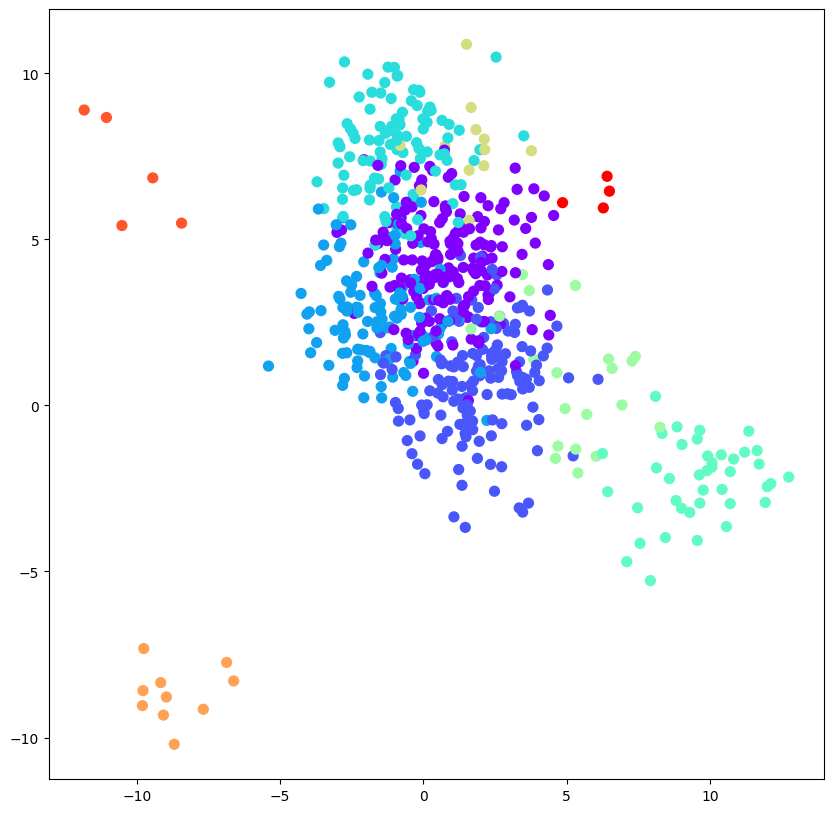

In [30]:
pos, colors = make_blobs(n_samples=blob_dist,
                  random_state=0, cluster_std=1.5)
plt.figure(figsize=(10,10))
plt.scatter(pos[:, 0], pos[:, 1], c=colors, s=50, cmap='rainbow');

let's see what happens in a standard 80/20 train test split:

In [31]:
colors.shape

(666,)

In [32]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(pos, colors,\
                                                                    test_size=0.2,\
                                                                    random_state=seed)

We know that there are 10, colors, so let's check the color values of the whole data set"

In [33]:
# color values of whole data set
np.unique(colors, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([200, 150, 125, 100,  40,  20,  12,  10,   5,   4]))

And now let's make sure that all color values made it to the test set..

In [34]:
# these are the color values represented in the test set....
np.unique(y_test_2, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 9]),
 array([41, 32, 24, 18,  9,  5,  1,  3,  1]))

In [35]:
#compare to what's in the training set...
np.unique(y_train_2, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([159, 118, 101,  82,  31,  15,  11,   7,   5,   3]))

### We can make sure that all "classes" are represented in both the training and test set by using stratification

## 3.1 Stratified KFold

We can use a stratified KFold cross-validation generator to make sure all classes are included in the 5-KFolds during cross-validation.

You implement something like this:

In [36]:
strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

And when creating the test/train split, you set the keyword "stratify=" and you set it equal to the property you want to make sure is represented in both trainining and test sets.

This can be EITHER a feature OR a target:


In [38]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(pos, colors,\
                                                            test_size=0.2,\
                                                            stratify=colors,\
                                                            random_state=seed)

And now let's see the features in our test set:

In [39]:
np.unique(y_test_3, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([40, 30, 25, 20,  8,  4,  3,  2,  1,  1]))

# 3.  $\underline{{\rm The\ Random\ Forest\ Regressor}}$

The RF is a powerful regression tool.


## 3.1 How can we turn this into a regression problem?

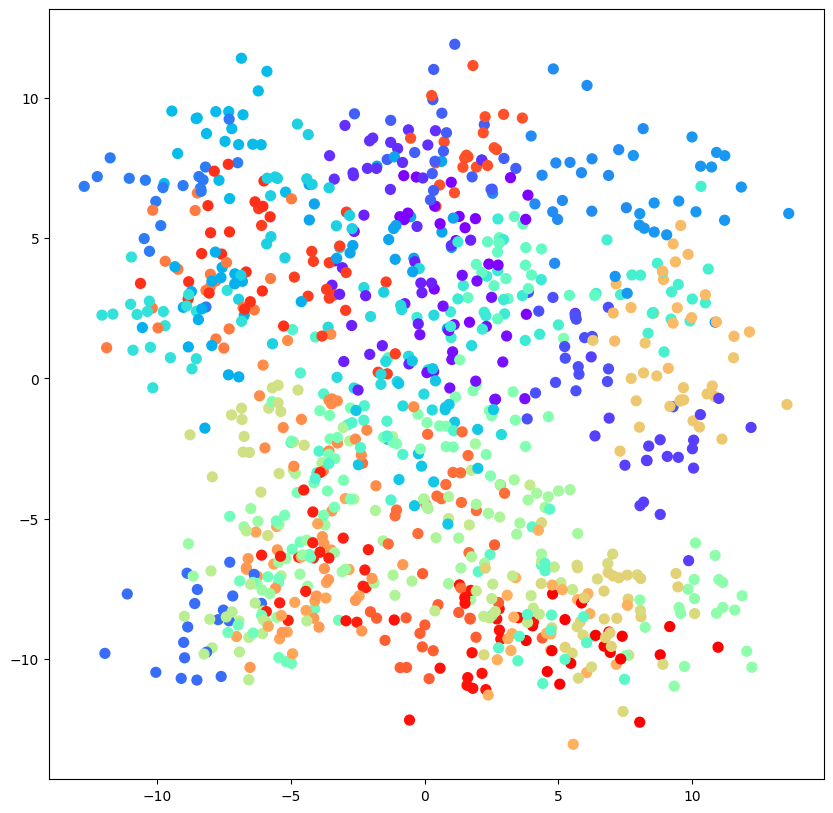

In [40]:
pos, colors = make_blobs(n_samples=1000, centers=50,
                  random_state=0, cluster_std=1.5)
plt.figure(figsize=(10,10))
plt.scatter(pos[:, 0], pos[:, 1], c=colors, s=50, cmap='rainbow');

In [41]:
features_reg = np.zeros((colors.shape[0],2))

In [42]:
features_reg[:,0] = colors
features_reg[:,1] = pos[:,1]
target_reg = pos[:,0] #now I've made the target a "continuous" variable

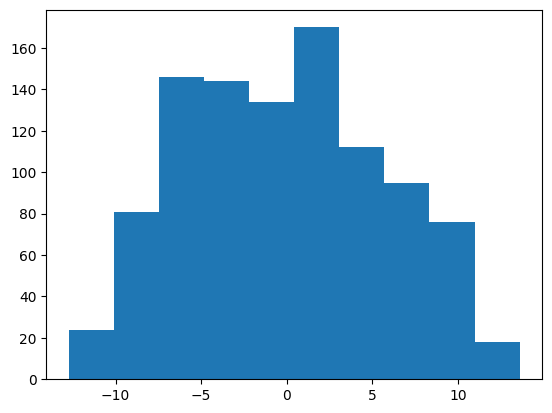

In [43]:
plt.hist(target_reg);

This is a nice "bell"-like distribution

## Normalizing data

What can we do if the range in our feature values is very large?

We can normalize our data!

### we can transform the data so it keeps the same distribution but we limit the range
### common normalizing strategies:
- for very large (or very small), i.e, $10^{12}$ or $10^{-5}$, we often just take the log base 10 of the values!

$log_{10}(y)$

- limit the range of the data between 0 and 1 with the function:

$y_{\rm norm} = \frac{y - y_{\rm min}}{y_{\rm max} - y_{\rm min}}$

Let's write a norming function

In [44]:
def norm_func(array):
  '''This function takes a 1D array and normalizes the elements
  such that they maintain the same distribution but range from 0 to 1
  '''
  n = (array - np.min(array))/(np.max(array)-np.min(array))
  return n

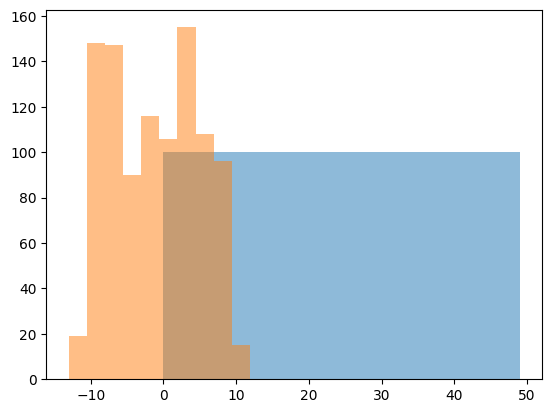

In [45]:
# here's our data
for i in range(features_reg.shape[1]):
  plt.hist(features_reg[:,i], alpha=0.5)

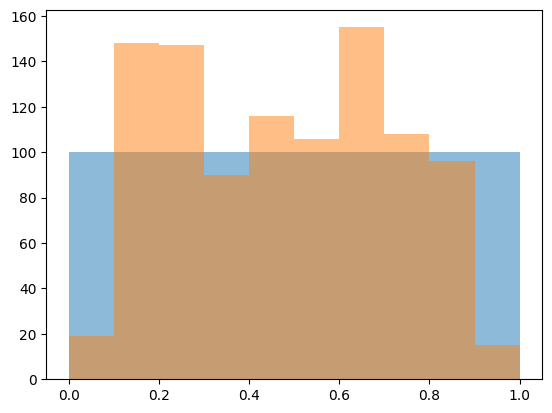

In [46]:
# here's our normed data
### DESCRIBE THE OUTPUT COMPARED TO THAT ABOVE
feature_0_normed = norm_func(features_reg[:,0])
feature_1_normed = norm_func(features_reg[:,1])

plt.hist(feature_0_normed, alpha=0.5)
plt.hist(feature_1_normed, alpha=0.5);

# $\underline{{\rm Exercise\ B.}}$
Run the complete Random Forest Regressor training.
- split the data
- get best params from a grid search, you will need to change your estimator and score !
- make the model
- fit the model
- get predictions from the model
- evaluate the model using a numerical score
- make a sctatter plot of true values on the x-axis and predictions on the y-axis

In [47]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(features_reg, target_reg,\
                                                                    test_size=0.2,\
                                                                    random_state=seed)

In [48]:
hyperparam_grid = {
'max_depth': [7,15],
#'max_features': [2, 4],
'min_samples_leaf': [2, 5, 10],
'min_samples_split': [2, 3, 5],
'n_estimators': [100]
}

In [49]:
def search_func(searcher, ftrs, targs):
    start = time.time()
    searcher.fit(ftrs, targs)
    print('mean test scores:',searcher.cv_results_['mean_test_score'])
    print('std test scores:',searcher.cv_results_['std_test_score'])
    print('mean train scores:',searcher.cv_results_['mean_train_score'])
    print('std train scores:',searcher.cv_results_['std_train_score'])
    print('best test score:',searcher.best_score_)
    print('best params:',searcher.best_params_ )
    print('number of minutes to perform the serach:', (time.time() - start)/60)
    return searcher.best_params_

In [50]:
search_2= GridSearchCV(estimator=RandomForestRegressor(), param_grid = hyperparam_grid,\
                        scoring='r2', cv = cv, verbose = 1,\
                           return_train_score=True)

In [51]:
features_reg.shape

(1000, 2)

In [52]:
results_reg = search_func(search_2, features_reg, target_reg)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
mean test scores: [0.76148868 0.75845371 0.75992212 0.75517257 0.75624544 0.76073038
 0.740933   0.7339491  0.73579472 0.90093039 0.90169234 0.90305884
 0.90583928 0.90431658 0.90426826 0.84806494 0.84741089 0.84734561]
std test scores: [0.02403628 0.01807822 0.02467613 0.01604982 0.01514779 0.02590702
 0.018636   0.01368717 0.02161724 0.00921439 0.00858762 0.00960036
 0.00921875 0.00871699 0.00960531 0.00906533 0.01115898 0.0109156 ]
mean train scores: [0.81604271 0.81087466 0.81486501 0.80042973 0.79742802 0.80358293
 0.78682205 0.78241827 0.78199384 0.96252914 0.962527   0.9604224
 0.93854729 0.93805889 0.9376613  0.88939044 0.89042972 0.88982288]
std train scores: [0.02005692 0.00922709 0.01278061 0.01316324 0.0084604  0.01657897
 0.01535011 0.01661907 0.01852142 0.00199158 0.00180893 0.00180558
 0.00340146 0.00288701 0.00261314 0.00698087 0.00558429 0.00805559]
best test score: 0.9058392790445497
best params: {'max_depth

In [53]:
model_reg = RandomForestRegressor(n_estimators=results_reg['n_estimators'], \
                                    max_depth=results_reg['max_depth'],\
                                    min_samples_leaf=results_reg['min_samples_leaf'],\
                                   min_samples_split=results_reg['min_samples_split'])

In [54]:
model_reg.fit(X_train_reg, y_train_reg)

RandomForestRegressor(max_depth=15, min_samples_leaf=5)

In [55]:
y_pred_reg = model_reg.predict(X_test_reg)

In [56]:
metrics.r2_score(y_test_reg, y_pred_reg)

0.8997774713587586

Text(0, 0.5, 'RF prediction')

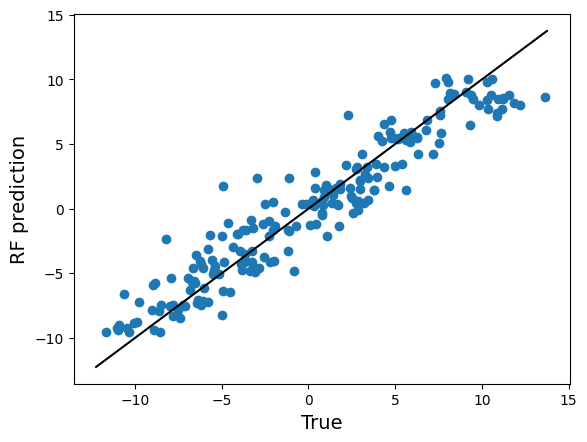

In [57]:
x = np.arange(y_test_reg.min()*1.05, y_test_reg.max()*1.05)
plt.scatter(y_test_reg, y_pred_reg)
plt.plot(x,x, c='k')
plt.xlabel('True', fontsize=14)
plt.ylabel('RF prediction', fontsize=14)

## 3.2 The feature importance attribute!

Feature ranking:
1. feature 0 (0.869668)
2. feature 1 (0.130332)


(-1.0, 2.0)

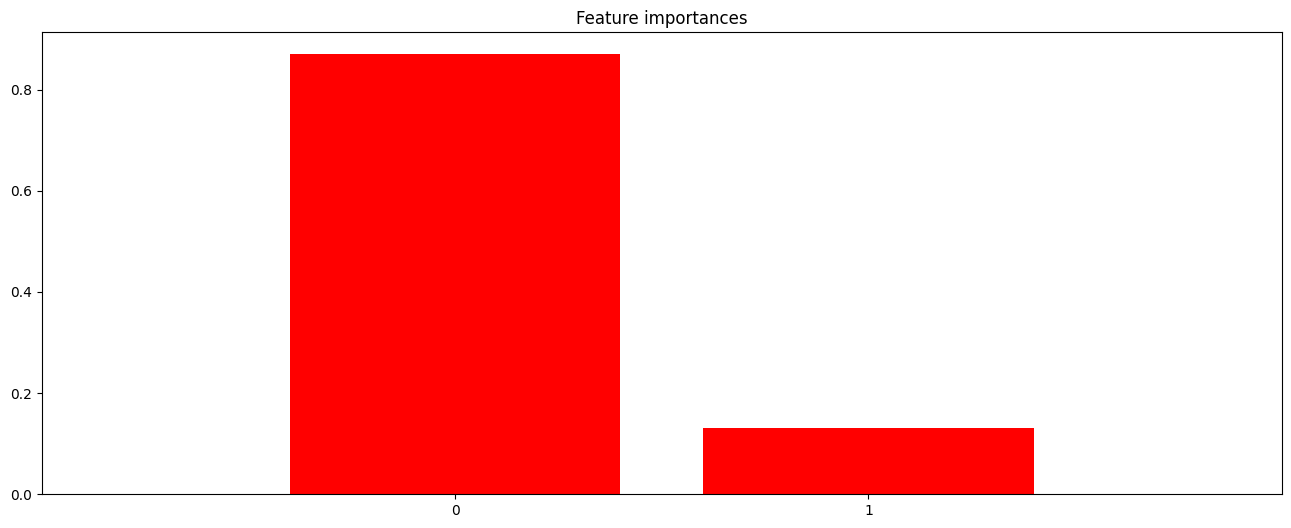

In [58]:
importances = model_reg.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(features_reg.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16,6))
plt.title("Feature importances")
plt.bar(range(features_reg.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(features_reg.shape[1]), indices)
plt.xlim([-1, features_reg.shape[1]])

This feature importance plot isn't too exciting because there are only two features. But it can be a powerful tool for analyzing results.

# $\underline{{\rm Exercise\ C.}}$: Discussion

What happens if we have imbalanced data in a regression problem? How would we know our data is imbalanced if there are no classses? What might we do to address the imbalance if we can't use stratification?

* You only need to jot your ideas down, this exercise doesn't involve code

